OrderedDict([(1280, 3201.0), (2560, 6402.0), (3840, 9603.0), (5120, 12804.0), (6400, 16005.0)]) OrderedDict([(1280, 3201.4), (2560, 6402.8), (3840, 9604.2), (5120, 12805.6), (6400, 16007.0)]) OrderedDict([(1280, 3200.0), (2560, 6400.0), (3840, 9600.0), (5120, 12800.0), (6400, 16000.0)])


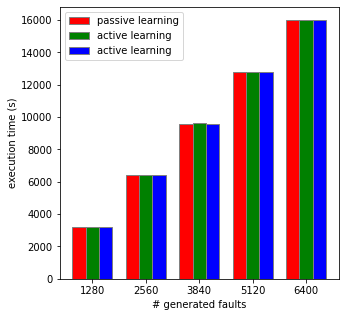

In [2]:
from numpy import sum,hstack, vstack, isnan, delete, where, random, asarray, count_nonzero, expand_dims, zeros, ones, around, absolute, append, all, argpartition, unique, array, average, concatenate
from numpy.random import randint, randn
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Reshape, Flatten, Conv1D, Conv1DTranspose, LeakyReLU, Dropout, Embedding, Input, Concatenate
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from pandas import read_csv, DataFrame
from matplotlib import pyplot as plt
import matlab.engine
from os import path
import os, sys, time, logging
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
from keras.wrappers.scikit_learn import KerasClassifier
from modAL.models import ActiveLearner
from functools import partial
from modAL.batch import uncertainty_batch_sampling
from scipy import spatial
from collections import OrderedDict
import tensorflow as tf

tf.get_logger().setLevel('ERROR')
sys.setrecursionlimit(10000)
#random.seed(123)
#eng = matlab.engine.start_matlab()
class BreakOutOfALoop(Exception): pass

def my_print(*args):  
    f = open("outputs.txt", "a")
    f.write('\r\n'.join(str(x) for x in args))  
    f.close()
    #print('\r',''.join(str(x) for x in args), end="                         ")

# define the standalone discriminator model
def define_discriminator(in_shape):
    model = Sequential()
	# downsample
    model.add(Conv1D(64, 4, padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
	# downsample
    model.add(Conv1D(64, 4, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
	# classifier
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
	# compile model
    opt = RMSprop(learning_rate=0.0001)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

# define the standalone generator model
def define_generator(latent_dim, in_dim):
    model = Sequential()
	
    n_nodes = 128 * input_dim
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((input_dim, 128)))
    model.add(Conv1DTranspose(128, 4, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv1DTranspose(128, 4, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv1D(1, input_dim, activation='tanh', padding='same'))
    return model

# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
    discriminator.trainable = False
    model = Sequential()
	# add generator
    model.add(generator)
	# add the discriminator
    model.add(discriminator)
	# compile model
    opt = RMSprop(learning_rate=0.0001)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

def load_real_samples():    
    try:
        df = read_csv('data.csv', index_col=False).drop_duplicates()
        df = df.loc[(df['type_val'] < 7) & 
                                (df['event_val'] < 7) & 
                                (df['effect_val'] < 7)]
        return df
    except FileNotFoundError:
        return DataFrame(columns=['type_val', 'event_val', 'effect_val', 'label'], data=[])

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    
    x_input = randn(latent_dim * n_samples)
    
    X = x_input.reshape(n_samples, latent_dim)
    
    return X

def generate_random_samples(n_samples):
    samples = zeros((n_samples, 3))
    for i in range(n_samples):
        #fault types: 
        #   0:stuck-at
        #   1:package drop
        #   2:offset
        #   3:bit
        #   4:delay
        #   5:noise
        #fault events:
        #   0: failure_prob
        #   1: MTTF
        #   2: deterministic
        #fault effects:
        #   0:once
        #   1:const
        #   2:inf
        #   3:MTTR
        #samples[i, 0] = 2 #offset fault
        samples[i, 0] = random.uniform(0, 7)
        #samples[i, 2] = 2 #deterministic
        samples[i, 1] = random.uniform(0, 7)
        #samples[i, 4] = 1 #const
        samples[i, 2] = random.uniform(0, 7)
    
    return samples

def generate_real_samples(dataset, n_samples):       
    
    X = generate_random_samples(n_samples)         
    y = label_samples(dataset, X)
    return X, y    

def generate_fake_samples(generator, latent_dim, n_samples):    
    Z = generate_latent_points(latent_dim, n_samples)    
    X = generator.predict(Z)
    return X, zeros((n_samples, 1))



def label_samples(dataset, samples):   
    
    n_samples = len(samples)
    y = zeros(n_samples)
    new_datalist = list()
    for i in range(n_samples):
        sample = samples[i]           
        try:
            if isnan(sum(sample)):
                y[i] = 0
                
                raise BreakOutOfALoop
            for d in new_datalist:
                if (d[0] == sample[0]) & (d[1] == sample[1]) & (d[2] == sample[2]):
                    y[i] = d[3]  
                    
                    raise BreakOutOfALoop
            
            df = dataset.loc[(dataset['type_val'] == sample[0]) & 
                                (dataset['event_val'] == sample[1]) & 
                                (dataset['effect_val'] == sample[2]) ]
            
            if df.size > 0:
                
                y[i] = df.iloc[0]['label'] 
            else:
                start = time.time()
                data = [float(num) for num in sample]                
                data[1] = round(data[1], 2)
                sample_m = matlab.double(data)[0]           
                
                y[i] = eng.ACCwithFI(sample_m)   
                
                if isnan(y[i]):
                    y[i] = 0.
                data.append(y[i])
                my_print(time.time() - start)
                new_datalist.append(data)
        except BreakOutOfALoop:
            continue
    if len(new_datalist) > 0:
        df = DataFrame(columns = dataset.columns, data = new_datalist)        
        dataset = dataset.append(df, ignore_index=True)                                              
        dataset.to_csv('data.csv', index=False, float_format='%.2f')                                                        
                                                          
    return y

def normalize_samples(samples):
    samples = expand_dims(samples, axis=-1)
    return (samples - 3.5)/3.5

def denormalize_samples(samples):
    samples_n = samples.reshape((samples.shape[0], samples.shape[1]))
    samples_u = unique(samples_n * 3.5 + 3.5, axis=0)
    
    l_unique = samples_u.shape[0]
    l_in = samples_n.shape[0]
    #print(l_unique, ' unique items out of ', l_in)
    return samples_u

def train_passive(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=32):    
         
    pool_size = 4*n_batch
    h_batch = int(n_batch/2)
    results = zeros((n_epochs,2))
    Z_pool = generate_latent_points(latent_dim, pool_size)        
    X_fake = g_model.predict(Z_pool)
    X_pool  = denormalize_samples(X_fake)    
    y_pool = label_samples(dataset, X_pool) 
    
    dataset_train = append(X_pool, expand_dims(y_pool, axis=-1), axis=1)
    
    dataset_l1 = dataset.loc[dataset['label'] == 1].head(pool_size).to_numpy()
    dataset_train = append(dataset_train, dataset_l1, axis=0)
     
    for i in range(1,n_epochs+1):        
        start = time.time()  
        pos_size = len(y_pool[y_pool==1])
        test_results[i,0] = pos_size
        acc = pos_size/pool_size
        print('passive accuracy for epoch ', i, ': ', acc, ' and positive labels: ', pos_size)
        
        dataset_l1 = dataset_train[dataset_train[:,-1] == 1]    
        ix = randint(dataset_l1.shape[0], size=h_batch)
        d1_loss,_ = d_model.train_on_batch(normalize_samples(dataset_l1[ix,:-1])  ,dataset_l1[ix,-1])
        dataset_l0 = dataset_train[dataset_train[:,-1] == 0] 
        #dataset_train = delete(dataset_train, ix, axis=0)
        ix = randint(dataset_l0.shape[0], size=h_batch)
        d2_loss,_ = d_model.train_on_batch(normalize_samples(dataset_l0[ix,:-1])  ,dataset_l0[ix,-1])
        #dataset_train = delete(dataset_train, ix, axis=0)
        Z_input = generate_latent_points(latent_dim, n_batch)
        y_gan = ones((n_batch, 1))
        g_loss = gan_model.train_on_batch(Z_input, y_gan)
        Z_pool = generate_latent_points(latent_dim, pool_size)        
        X_fake = g_model.predict(Z_pool)
        X_pool  = denormalize_samples(X_fake)
        
        y_pool = label_samples(dataset, X_pool) 
        dataset_train = append(dataset_train, append(X_pool, expand_dims(y_pool, axis=-1), axis=1),axis=0)
        end = time.time()
        results[i,1] = end - start
        dataset = load_real_samples()
        
        #my_print('>%d,d1=%.3f,d2=%.3f,g=%.3f' % (i, d1_loss, d2_loss, g_loss))  
    
       
    #d_model.save('discriminator.h5')
    #g_model.save('generator.h5')
    return results

def train_active(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=32):  
    results = zeros((n_epochs,2))
    classifier = KerasClassifier(build_fn = lambda:d_model, verbose=0)    
    pool_size = 4*n_batch
    h_batch = int(n_batch/2)
    preset_batch = partial(uncertainty_batch_sampling, n_instances=h_batch)
    learner = ActiveLearner(estimator=classifier, query_strategy=preset_batch)
    Z_pool = generate_latent_points(latent_dim, pool_size)        
    X_fake = g_model.predict(Z_pool)
    X_pool  = denormalize_samples(X_fake)
    y_pool = label_samples(dataset, X_pool) 
    dataset_train = append(X_pool, expand_dims(y_pool, axis=-1), axis=1)
    dataset_l1 = dataset.loc[dataset['label'] == 1].head(pool_size).to_numpy()
    dataset_train = append(dataset_train, dataset_l1, axis=0)
    learner.teach(normalize_samples(dataset_train[:,:-1]), dataset_train[:,-1]) 
    
    for i in range(1,n_epochs+1): 
        start = time.time()  
        pos_size = len(y_pool[y_pool==1])
        results[i,0] = pos_size
        acc = pos_size/pool_size
        my_print('active acc for epoch ', i, ': ', acc, ' and + lbls: ', pos_size)
        dataset_l1 = dataset_train[dataset_train[:,-1] == 1]  
        X_train = normalize_samples(dataset_l1[:,:-1])
        
        ix,_ = learner.query(X_train)   
        
        #learner.teach(X_train[ix], dataset_l1[ix,-1]) 
        d1_loss,_ = d_model.train_on_batch(X_train[ix] ,dataset_l1[ix,-1])
        dataset_l0 = dataset_train[dataset_train[:,-1] == 0]  
        X_train = normalize_samples(dataset_l0[:,:-1])
        ix,_ = learner.query(X_train)     
        #learner.teach(X_train[ix], dataset_l0[ix,-1])              
        d2_loss,_ = d_model.train_on_batch(X_train[ix] ,dataset_l0[ix,-1])           
        Z_input = generate_latent_points(latent_dim, n_batch)
        y_gan = ones((n_batch, 1))
        g_loss = gan_model.train_on_batch(Z_input, y_gan)        
        Z_pool = generate_latent_points(latent_dim, pool_size)        
        X_fake = g_model.predict(Z_pool)
        X_pool  = denormalize_samples(X_fake)         
        y_pool = label_samples(dataset, X_pool)   
        dataset_train = append(dataset_train, append(X_pool, expand_dims(y_pool, axis=-1), axis=1),axis=0)
        end = time.time()
        results[i,1] = end - start
        dataset = load_real_samples()         
        #my_print('>%d,d1=%.3f,d2=%.3f,g=%.3f' % (i, d1_loss, d2_loss, g_loss))  
    #g_model.save('generator_active.h5')
    #d_model.save('discriminator_active.h5')
    return results
        
def build_model(new_model, input_dim, latent_dim, n_epochs, n_batch, passive=True):       
    dataset = load_real_samples()
    discriminator = define_discriminator((input_dim, 1))
    generator = define_generator(latent_dim, input_dim)
    if not new_model:
        discriminator = load_model('discriminator.h5')
        generator = load_model('generator.h5', compile=False)
        if not passive:
            discriminator = load_model('discriminator_active.h5')
            generator = load_model('generator_active.h5', compile=False)
        
    gan_model = define_gan(generator, discriminator) 
    if passive:
        results = train_passive(generator, discriminator, gan_model, dataset, latent_dim, n_epochs, n_batch)
        df = DataFrame(data={'epoch':[i for i in range(1, n_epoch+1)], 'faults':list(results[:,0])})
        #if new_model:
        #    df.to_csv("train_results_passive.csv", index=False)
        #else:
        #    df.to_csv("train_results_passive.csv", index=False, mode='a', header=False)
        return results
    results = train_active(generator, discriminator, gan_model, dataset, latent_dim, n_epochs, n_batch)
    df = DataFrame(data={'epoch':[i for i in range(1, n_epoch+1)], 'faults':list(results[:,0])})
    #if new_model:
    #    df.to_csv("train_results_active.csv", index=False)
    #else:
    #    df.to_csv("train_results_active.csv", index=False, mode='a', header=False)
    return results
def test_model(latent_dim, test_size, model='passive'):
    dataset = load_real_samples()
    
    generator = load_model('generator.h5', compile=False)
    if model != 'passive':
        generator = load_model('generator_active.h5', compile=False)
    Z_input = generate_latent_points(latent_dim, test_size)
        
    X_input = generator.predict(Z_input)    
    X = denormalize_samples(X_input)
    y = label_samples(dataset, X)
    
    pos_size = len(y[y==1])
    acc = pos_size/test_size
    my_print(model, ' acc for size ', test_size, ': ', acc, ' & + labels: ', pos_size)
    return pos_size

def test_rand(test_size):
    dataset = load_real_samples()
    samples = generate_random_samples(test_size)    
    y = label_samples(dataset, samples)
    pos_size = len(y[y==1])
    acc = pos_size/test_size
    my_print('random accuracy for size ', test_size, ': ', acc, ' and positive labels: ', pos_size)
    return pos_size

def show_test_results(r_rand, r_passive, r_active):
    plt.rcParams["figure.figsize"] = (5,5)
    x = array(list(r_passive.keys()))
    y0 = list(r_rand.values())
    y1 = list(r_passive.values())
    y2 = list(r_active.values())    
    plt.xlabel('# gernerated faults')
    plt.ylabel('# critical faults')
    plt.xticks(x[x%20==0])
    plt.plot(x, y0, label="random")
    plt.plot(x, y1, label="passive learning")
    plt.plot(x, y2, label="active learning")    
    plt.legend()
    plt.savefig("test_results.pdf")
    plt.show()
    df = DataFrame(data={'test size':x, 'random':y0, 'passive':y1, 'active':y2})
    df.to_csv("test_results.csv", index=False)
    
def show_train_results_active(r_active=None):

    if r_active is None:
        df = read_csv('train_results_active.csv', index_col=False)
        r_active = OrderedDict()
        for index, row in df.iterrows():
            r_active[row['epoch']] = row['faults']

    plt.rcParams["figure.figsize"] = (5,5)
    x = array(list(r_active.keys()))
    
    y2 = list(r_active.values())
    plt.xlabel('# training epochs')
    plt.ylabel('# critical faults')
    plt.xticks(x[x%10==0])
    
    plt.plot(x, y2)    
    
    plt.savefig("train_results_active.pdf")
    plt.show()
    
    
def show_train_results(r_passive=None, r_active=None):

    if r_passive is None:
        df = read_csv('train_results_passive.csv',  index_col=False)
        print(df[:10].sum(), df[:10].sum()/1280)
        print(df[:20].sum(), df[:20].sum()/2560)
        print(df[:30].sum(), df[:30].sum()/3840)
        print(df[:40].sum(), df[:40].sum()/5120)
        print(df[:50].sum(), df[:50].sum()/6400)
        print(df[:60].sum(), df[:60].sum()/7680)
        print(df[:70].sum(), df[:70].sum()/8960)
        print(df[:80].sum(), df[:80].sum()/10240)
        print(df[:90].sum(), df[:90].sum()/11520)
        print(df.sum(), df.sum()/12800)
        r_passive = OrderedDict()
        for index, row in df.iterrows():
            r_passive[row['epoch']] = row['faults']

    if r_active is None:
        df = read_csv('train_results_active.csv', index_col=False)
        print(df[:10].sum(), df[:10].sum()/1280)
        print(df[:20].sum(), df[:20].sum()/2560)
        print(df[:30].sum(), df[:30].sum()/3840)
        print(df[:40].sum(), df[:40].sum()/5120)
        print(df[:50].sum(), df[:50].sum()/6400)
        print(df[:60].sum(), df[:60].sum()/7680)
        print(df[:70].sum(), df[:70].sum()/8960)
        print(df[:80].sum(), df[:80].sum()/10240)
        print(df[:90].sum(), df[:90].sum()/11520)
        print(df.sum(), df.sum()/12800)
        r_active = OrderedDict()
        for index, row in df.iterrows():
            r_active[row['epoch']] = row['faults']

    plt.rcParams["figure.figsize"] = (5,5)
    x = array(list(r_passive.keys()))
    y1 = list(r_passive.values())
    y2 = list(r_active.values())
    plt.xlabel('# iterations')
    plt.ylabel('# critical faults')
    plt.xticks(x[x%10==0])
    plt.plot(x, y1, label="passive learning")
    plt.plot(x, y2, label="active learning")    
    plt.legend()
    plt.savefig("train_results.pdf")
    plt.show()
    
def compare_time():
    #df_p = read_csv('train_results_passive.csv',  index_col=False)
    #df_a = read_csv('train_results_active.csv',  index_col=False)
    r_passive = OrderedDict()
    r_active = OrderedDict()
    r_random = OrderedDict()
    for i in range(1280,7000, 1280):        
        r_passive[i] = i*2.5+i/1280
        r_active[i] = i*2.5+1.4*i/1280
        r_random[i] = i*2.5
    
    
    barWidth = 0.25
    fig = plt.subplots(figsize =(5, 5))

    
    # Set position of bar on X axis
    br1 = [i for i in range(5)]
    br2 = [x + barWidth for x in br1]
    br3 = [x + barWidth for x in br2]
    print(r_passive, r_active, r_random)

    # Make the plot
    plt.bar(br1, list(r_passive.values()), color ='r', width = barWidth,
            edgecolor ='grey', label ='passive learning')
    plt.bar(br2, list(r_active.values()), color ='g', width = barWidth,
            edgecolor ='grey', label ='active learning')
    plt.bar(br3, list(r_random.values()), color ='b', width = barWidth,
            edgecolor ='grey', label ='active learning')
    
    # Adding Xticks
    plt.xlabel('# generated faults')
    plt.ylabel('execution time (s)')
    plt.xticks([r+barWidth for r in range(5)],
            ['1280', '2560', '3840', '5120','6400'])
    
    plt.legend()
    plt.savefig("time.pdf",bbox_inches='tight')
    plt.show()

def compare_effort():
    df_p = read_csv('train_results_passive.csv',  index_col=False)
    df_a = read_csv('train_results_active.csv',  index_col=False)
    r_passive = OrderedDict()
    r_active = OrderedDict()
    for i in range(100,560, 100):
        for j in range(100):
            if df_p['faults'][:j].sum() > i:
                r_passive[i] = j*128
                break
    for i in range(100,560, 100):
        for j in range(100):
            if df_a['faults'][:j].sum() > i:
                r_active[i] = j*128
                break
    
    barWidth = 0.25
    fig = plt.subplots(figsize =(5, 5))

    
    # Set position of bar on X axis
    br1 = [i for i in range(5)]
    br2 = [x + barWidth for x in br1]
    br3 = [x + barWidth for x in br2]
    print(r_passive, r_active)

    # Make the plot
    plt.bar(br1, list(r_passive.values()), color ='r', width = barWidth,
            edgecolor ='grey', label ='passive learning')
    plt.bar(br2, list(r_active.values()), color ='g', width = barWidth,
            edgecolor ='grey', label ='active learning')
    plt.bar(br3, [1000,2000,3000,4000,5000], color ='b', width = barWidth,
            edgecolor ='grey', label ='active learning')
    
    # Adding Xticks
    plt.xlabel('# critical fault')
    plt.ylabel('labeling effort')
    plt.xticks([r+barWidth for r in range(5)],
            ['100', '200', '300', '400','500'])
    
    plt.legend()
    plt.savefig("effort.pdf")
    plt.show()
    
    
def compare_train(new_model, input_dim, latent_dim, n_epochs, n_batch):
    train_results_passive = build_model(new_model, input_dim, latent_dim,n_epochs, n_batch)
    train_results_active = build_model(new_model,input_dim, latent_dim,n_epochs, n_batch, passive = False)
    show_train_results(train_results_passive, train_results_active)

def compare_test(latent_dim):
    test_results_rand = OrderedDict()
    test_results_active = OrderedDict()
    test_results_passive = OrderedDict()
    for test_size in range(200,1200,200):
        test_results_rand[test_size] = test_rand(test_size)
        test_results_passive[test_size] = test_model(latent_dim, test_size, 'passive')
        test_results_active[test_size] = test_model(latent_dim, test_size, 'active')
    
    show_test_results(test_results_rand, test_results_passive, test_results_active)

input_dim = 3
latent_dim = 100
n_epoch = 10
n_batch = 32
new_model = True
#generate_real_samples(load_real_samples(), 4)
#show_train_results()
#open("outputs.txt", "x")
#for n_epoch in range(10,110,10):
#    build_model(new_model,input_dim, latent_dim,n_epochs, n_batch)
#compare_train(new_model,input_dim, latent_dim,n_epochs, n_batch)
#show_train_results()
compare_time()
#compare_test(latent_dim)
#avg fault coverage
#single signal, multiple signals also experiments on bits
# also laeling and training effort for a specific level of coverage..also chain faults
#plot the signals to show the effect of fault

In [2]:
pip install modAL

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import matlab, matlab.engine
import numpy as np
eng = matlab.engine.start_matlab()
d = [round(float(x), 2) for x in np.array(  [3.859999895095825,7.139999866485596,4.489999771118164])]              
print(type(d[0]), d)                
sample_m = matlab.double(d)[0]           

print(eng.ACCwithFI(sample_m))

In [ ]:
import pandas as pd
df = pd.read_csv('data.csv', index_col=False).drop_duplicates()
df = df.loc[(df['type_val'] < 6) & 
                        (df['event_val'] < 6) & 
                        (df['effect_val'] < 6)]
print(df.shape)

In [ ]:
import numpy as np
x = np.array([[1,2],[2,3],[3,4]])
y = np.array([1,0,1])
x[np.argwhere(y==1)].reshape((x.shape[0], x.shape[2]))